DAT565E
Final Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/deep_learning_dataset/Finalproject/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/deep_learning_dataset/Finalproject/test.csv')

In [4]:
df_train.head()

,text,sentiment
0,"Now, I won't deny that when I purchased this o...",neg
1,"The saddest thing about this ""tribute"" is that...",neg
2,Last night I decided to watch the prequel or s...,neg
3,I have to admit that i liked the first half of...,neg
4,I was not impressed about this film especially...,neg


In [5]:
df_test.head()

,text,sentiment
0,"My daughter liked it but I was aghast, that a ...",neg
1,I... No words. No words can describe this. I w...,neg
2,this film is basically a poor take on the old ...,neg
3,"This is a terrible movie, and I'm not even sur...",neg
4,First of all this movie is a piece of reality ...,pos


## Data preprocessing

In [6]:
df = pd.concat([df_train, df_test], ignore_index=True)
df.head()

,text,sentiment
0,"Now, I won't deny that when I purchased this o...",neg
1,"The saddest thing about this ""tribute"" is that...",neg
2,Last night I decided to watch the prequel or s...,neg
3,I have to admit that i liked the first half of...,neg
4,I was not impressed about this film especially...,neg


In [7]:
df1 = pd.get_dummies(df, columns = ['sentiment'])

In [8]:
df1.head()

,text,sentiment_neg,sentiment_pos
0,"Now, I won't deny that when I purchased this o...",1,0
1,"The saddest thing about this ""tribute"" is that...",1,0
2,Last night I decided to watch the prequel or s...,1,0
3,I have to admit that i liked the first half of...,1,0
4,I was not impressed about this film especially...,1,0


In [9]:
df2 = df1.drop('sentiment_neg', axis=1)
df2.head()

,text,sentiment_pos
0,"Now, I won't deny that when I purchased this o...",0
1,"The saddest thing about this ""tribute"" is that...",0
2,Last night I decided to watch the prequel or s...,0
3,I have to admit that i liked the first half of...,0
4,I was not impressed about this film especially...,0


In [10]:
df2.sentiment_pos.value_counts()

0    25000
1    25000
Name: sentiment_pos, dtype: int64

In [11]:
# neg=df2[df2['sentiment_pos']==0].sample(n=20000)
# df2 = pd.concat([neg, df2], ignore_index=True)
# df2.head()

In [12]:
df2.sentiment_pos.value_counts()

0    25000
1    25000
Name: sentiment_pos, dtype: int64

In [13]:
df2.sentiment_pos=df2.sentiment_pos.astype('float64')

In [14]:
from sklearn.model_selection import train_test_split
rev=df2["text"]
target=df2["sentiment_pos"]
x_train, x_test, y_train, y_test = train_test_split(rev,target,test_size=0.1,random_state=0,stratify=target) #split the dataset to train, validation and test. Like we did before.

In [15]:
df2

,text,sentiment_pos
0,"Now, I won't deny that when I purchased this o...",0.0
1,"The saddest thing about this ""tribute"" is that...",0.0
2,Last night I decided to watch the prequel or s...,0.0
3,I have to admit that i liked the first half of...,0.0
4,I was not impressed about this film especially...,0.0
...,...,...
49995,"For one thing, he produced this movie. It has ...",0.0
49996,The title comes from an alteration an adolesce...,1.0
49997,Christopher Nolan's first film is a 'no budget...,1.0
49998,The story is shortly about the faith-lacking b...,0.0


## Here is a common-sense, non-machine learning baseline prediction

In [16]:
average_rating=y_test.mean()
mae=0
for rating in y_test:
  mae+=abs(rating-average_rating)
print(mae/len(y_test))

0.5


In this case, the mean absolute percent error is about 0.5.  

In [17]:
df2 = df2.dropna()

In [18]:
len(df2)

50000

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Sentiment Bar Plot')

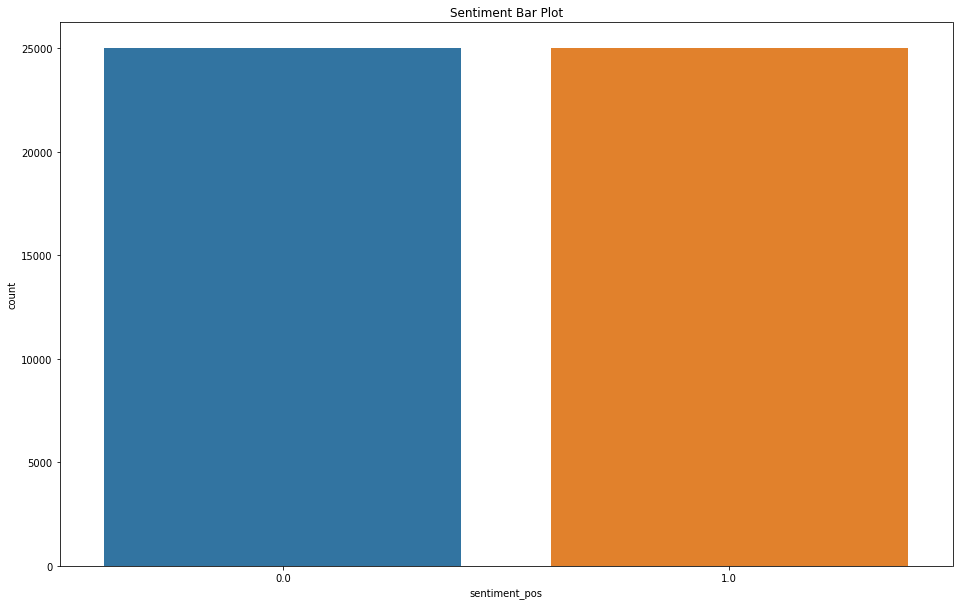

In [19]:
plt.figure(figsize = (16,10))
sns.countplot(df2['sentiment_pos'])
plt.title("Sentiment Bar Plot")

## Preparing data for model

In [20]:
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
from keras.layers import Dense
from keras.layers import Dropout

# Number of words to consider as features
max_features = 10000

maxlen = 200 #Maximum sequence length
batch_size = 64 #the number of rows of input for each step

#Tokenizing
tokenizer=Tokenizer(max_features,oov_token="<?>")
tokenizer.fit_on_texts(x_train)
X_train=tokenizer.texts_to_sequences(x_train)
X_test=tokenizer.texts_to_sequences(x_test) #Those 4 rows transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from 1 - max_features

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')


print('Pad sequences (samples x text length)')
X_train = pad_sequences(X_train, maxlen=maxlen) #make sure that the length of every array reaches maxlen by filling zeros in front of all arrays. Not all text contents have the maxlen we set in original dataset.
X_test = pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

45000 train sequences
5000 test sequences
Pad sequences (samples x text length)
X_train shape: (45000, 200)
X_test shape: (5000, 200)


## SimpleRNN

In [21]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
from keras.layers import Dense
from keras.layers import Dropout

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
embedding_dim = 64
#input_dim, output_dim, input_lenght
model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 64)`.
# when embedding connects to RNN or LSTM layers, flatten() is not needed.
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(16, return_sequences=True))
model.add(SimpleRNN(32)) # default activation is "tanh"
model.add(Dense(1)) #this means we have only 1 number (1,2,3,4,5) to represent output rating.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           640000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 200, 32)           3104      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 200, 16)           784       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                1568      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 645,489
Trainable params: 645,489
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc') #mape: Mean Absolute Percentage Error
 #mape: Mean Absolute Percentage Error
history = model.fit(X_train, y_train,
                    epochs=10,
                    steps_per_epoch = 256,
                    batch_size=batch_size,
                   validation_data=(X_test,y_test))

keras.backend.clear_session()
del model

Epoch 1/10
256/256 [==============================] - 96s 366ms/step - loss: 0.5285 - acc: 0.8018 - val_loss: 0.6129 - val_acc: 0.7694
Epoch 2/10
256/256 [==============================] - 94s 367ms/step - loss: 0.4273 - acc: 0.8503 - val_loss: 0.5273 - val_acc: 0.8426
Epoch 3/10
256/256 [==============================] - 94s 367ms/step - loss: 0.4047 - acc: 0.8455 - val_loss: 0.5611 - val_acc: 0.7946
Epoch 4/10
256/256 [==============================] - 95s 371ms/step - loss: 0.2922 - acc: 0.9107 - val_loss: 0.6086 - val_acc: 0.8118
Epoch 5/10
256/256 [==============================] - 93s 363ms/step - loss: 0.3701 - acc: 0.8807 - val_loss: 0.5504 - val_acc: 0.8332
Epoch 6/10
256/256 [==============================] - 94s 367ms/step - loss: 0.3910 - acc: 0.8683 - val_loss: 0.8934 - val_acc: 0.7924
Epoch 7/10
256/256 [==============================] - 94s 367ms/step - loss: 0.3456 - acc: 0.9032 - val_loss: 0.8877 - val_acc: 0.8200
Epoch 8/10
256/256 [==============================] - 9

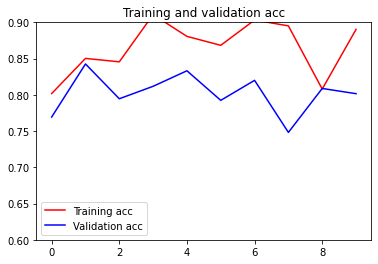

In [24]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.ylim(ymax=0.9,ymin=0.6)

plt.show()

## CNN

In [34]:
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(Embedding(max_features, 64, input_length=maxlen))
model.add(layers.Conv1D(64, 5, activation='relu')) #Note, we use Conv1d here instead of Conv2d in Lab 3. Thats because the input shape changes. (decrease)
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           640000    
                                                                 
 conv1d (Conv1D)             (None, 196, 64)           20544     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 65, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 61, 32)            10272     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 3

In [36]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc') #mape: Mean Absolute Percentage Error
history = model.fit(X_train, y_train,
                    epochs=20,
                    steps_per_epoch = 256,
                    batch_size=batch_size,
                   validation_data=(X_test,y_test))

keras.backend.clear_session()
del model

Epoch 1/20
256/256 [==============================] - 2s 5ms/step - loss: 0.6655 - acc: 0.6487 - val_loss: 0.4934 - val_acc: 0.7880
Epoch 2/20
256/256 [==============================] - 1s 5ms/step - loss: 0.6524 - acc: 0.7684 - val_loss: 0.4413 - val_acc: 0.8260
Epoch 3/20
256/256 [==============================] - 1s 5ms/step - loss: 0.4136 - acc: 0.8392 - val_loss: 0.3872 - val_acc: 0.8578
Epoch 4/20
256/256 [==============================] - 1s 4ms/step - loss: 0.6886 - acc: 0.8019 - val_loss: 0.9717 - val_acc: 0.5262
Epoch 5/20
256/256 [==============================] - 1s 4ms/step - loss: 0.4241 - acc: 0.8345 - val_loss: 0.4056 - val_acc: 0.8546
Epoch 6/20
256/256 [==============================] - 1s 4ms/step - loss: 0.3490 - acc: 0.8807 - val_loss: 0.4256 - val_acc: 0.8594
Epoch 7/20
256/256 [==============================] - 1s 4ms/step - loss: 0.3643 - acc: 0.8782 - val_loss: 0.4182 - val_acc: 0.8598
Epoch 8/20
256/256 [==============================] - 1s 4ms/step - loss: 0.

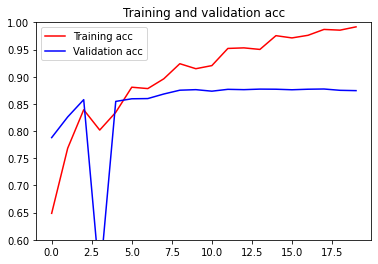

In [37]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.ylim(ymax=1,ymin=0.6)

plt.show()

## LSTM

In [ ]:
model = Sequential()
model.add(Embedding(max_features,64, input_length=maxlen))
model.add(layers.LSTM(32,dropout=0.2,recurrent_dropout=0.2)) #notice that we add recurrent_dropout here. 
model.add(layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           640000    
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 652,449
Trainable params: 652,449
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc') 
history = model.fit(X_train, y_train,
                    epochs=20,
                    steps_per_epoch = 256,
                    batch_size=batch_size,
                   validation_data=(X_test,y_test))

keras.backend.clear_session()
del model

Epoch 1/20
256/256 [==============================] - 159s 610ms/step - loss: 0.6703 - acc: 0.6899 - val_loss: 0.4970 - val_acc: 0.8078
Epoch 2/20
256/256 [==============================] - 156s 608ms/step - loss: 0.5363 - acc: 0.7671 - val_loss: 0.6048 - val_acc: 0.6966
Epoch 3/20
256/256 [==============================] - 155s 605ms/step - loss: 0.4732 - acc: 0.7988 - val_loss: 0.4027 - val_acc: 0.8492
Epoch 4/20
256/256 [==============================] - 154s 603ms/step - loss: 0.3928 - acc: 0.8543 - val_loss: 0.4365 - val_acc: 0.8514
Epoch 5/20
256/256 [==============================] - 155s 605ms/step - loss: 0.5406 - acc: 0.7404 - val_loss: 0.5680 - val_acc: 0.7116
Epoch 6/20
256/256 [==============================] - 154s 602ms/step - loss: 0.4884 - acc: 0.7865 - val_loss: 0.4805 - val_acc: 0.8582
Epoch 7/20
256/256 [==============================] - 154s 602ms/step - loss: 0.3541 - acc: 0.8798 - val_loss: 0.4471 - val_acc: 0.8740
Epoch 8/20
256/256 [============================

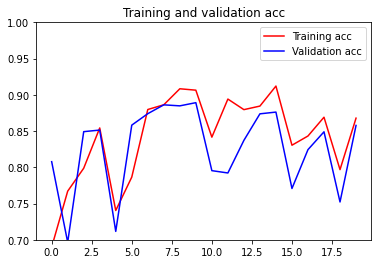

In [ ]:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.ylim(ymax=1,ymin=0.7)

plt.show()

## Bert

In [16]:

import re
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow_hub as hub
import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [17]:
df2

,text,sentiment_pos
0,"Now, I won't deny that when I purchased this o...",0.0
1,"The saddest thing about this ""tribute"" is that...",0.0
2,Last night I decided to watch the prequel or s...,0.0
3,I have to admit that i liked the first half of...,0.0
4,I was not impressed about this film especially...,0.0
...,...,...
49995,"For one thing, he produced this movie. It has ...",0.0
49996,The title comes from an alteration an adolesce...,1.0
49997,Christopher Nolan's first film is a 'no budget...,1.0
49998,The story is shortly about the faith-lacking b...,0.0


In [18]:
# Add a 'len' column to the DataFrame containing the number of words in each row of the 'text' column
df2['len'] = df2['text'].str.split().apply(len)

In [19]:
df2

,text,sentiment_pos,len
0,"Now, I won't deny that when I purchased this o...",0.0,137
1,"The saddest thing about this ""tribute"" is that...",0.0,313
2,Last night I decided to watch the prequel or s...,0.0,180
3,I have to admit that i liked the first half of...,0.0,162
4,I was not impressed about this film especially...,0.0,195
...,...,...,...
49995,"For one thing, he produced this movie. It has ...",0.0,147
49996,The title comes from an alteration an adolesce...,1.0,549
49997,Christopher Nolan's first film is a 'no budget...,1.0,108
49998,The story is shortly about the faith-lacking b...,0.0,287


In [20]:
df2['len'].describe()

count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: len, dtype: float64

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df2[['text','len']],df2.sentiment_pos, test_size=0.2, random_state=42, stratify=df2.sentiment_pos)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(40000, 2) (40000,) (10000, 2) (10000,)


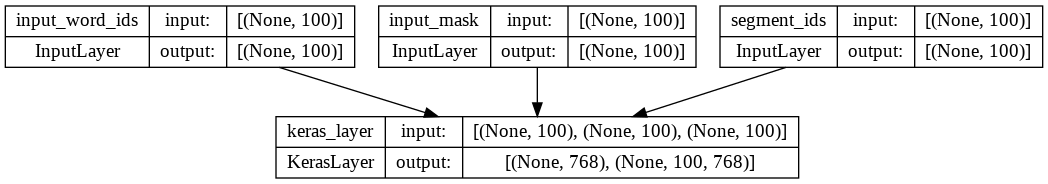

In [27]:
max_seq_length = 100

# Clear the TensorFlow session to remove any previous model or layer definitions
tf.keras.backend.clear_session()

# Define input layers for the model
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

# Use the BERT layer from TensorFlow Hub as a layer in the model
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=True) #use the smaller version of bert

# Pass the input layers through the BERT layer to obtain the output tensors
pooled_output, _ = bert_layer([input_word_ids, input_mask, segment_ids])

# Add fully conect layer
#dense1=Dense(128,activation='relu',name='dense1')(pooled_output)
#dense2=Dense(64,activation='relu',name='dense2')(dense1)
#output=Dense(1,activation='sigmoid',name='dense3')(dense2)

# Define the model using the input layers and the output tensors
model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)

tf.keras.utils.plot_model(model,'model_1.png',show_shapes=True)

In [28]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [29]:
!pip install bert-tensorflow==1.0.1
from bert import tokenization
tf.gfile = tf.io.gfile
tokenizer =tokenization.FullTokenizer(bert_layer.resolved_object.vocab_file.asset_path.numpy(),bert_layer.resolved_object.do_lower_case.numpy())

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
def bert_preprocess(sentence, tokenizer, max_seq_len=512):
    # Initialize empty lists for tokens, masks, and segments
    tokens = []
    masks = []
    segments = []

    # Iterate over each word in the sentence
    for word in sentence:
        # Tokenize the word
        word_tokens = tokenizer.tokenize(word)
        # Truncate the word tokens if necessary
        word_tokens = word_tokens[:max_seq_len - 2]
        # Add special tokens to the beginning and end of the word tokens
        seq = ["[CLS]"] + word_tokens + ["[SEP]"]
        # Convert the tokens to their corresponding IDs
        token = tokenizer.convert_tokens_to_ids(seq)
        # Pad the tokens with 0s if necessary
        padding_tokens = token + [0] * (max_seq_len - len(token))
        # Create a mask for the tokens
        mask = [1] * len(seq)
        # Pad the mask with 0s if necessary
        masking = mask + [0] * (max_seq_len - len(token))
        # Create a segment for the tokens
        segment = np.zeros(max_seq_len)
        
        # Add the padded tokens, mask, and segment to the respective lists
        tokens.append(padding_tokens)
        masks.append(masking)
        segments.append(segment)
    
    # Convert the lists to numpy arrays
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    
    return tokens, masks, segments


In [31]:
X_train_tokens, X_train_mask, X_train_segment=bert_preprocess(X_train.text.values.astype('str'),tokenizer,100)
X_test_tokens, X_test_mask, X_test_segment=bert_preprocess(X_test.text.values.astype('str'),tokenizer,100)

In [32]:
# Perform inference on the training data using the BERT model
X_train_pooled_output = model.predict([X_train_tokens, X_train_mask, X_train_segment])

# Perform inference on the test data using the BERT model
X_test_pooled_output = model.predict([X_test_tokens, X_test_mask, X_test_segment])


313/313 [==============================] - 9s 24ms/step


In [33]:
from sklearn.metrics import roc_auc_score

In [34]:
auc=[]
val_auc=[]
class LossHistory(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        self.history={'val_accuracy': []}


    def on_epoch_end(self, epoch, logs={}):
        ## on end of each epoch, we will get logs and update the self.history dict
        if logs.get('val_accuracy', -1) != -1:
            self.history['val_accuracy'].append(logs.get('val_accuracy'))
        auc_tr=(roc_auc_score(y_train,(self.model.predict(X_train_pooled_output))) )
        auc_test=(roc_auc_score (y_test, (self.model.predict(X_test_pooled_output) ) ) )
        print('\n  train_auc : ',auc_tr)
        print('  val_auc : ',auc_test)
        auc.append(auc_tr)
        val_auc.append(auc_test)
        loss=logs.get('loss')


In [35]:
filepath="model1_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_loss',  verbose=1, save_best_only=True, mode='auto')

history_own = LossHistory()

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max', patience=2, verbose=1)

In [38]:
from tensorflow.keras.layers import Input


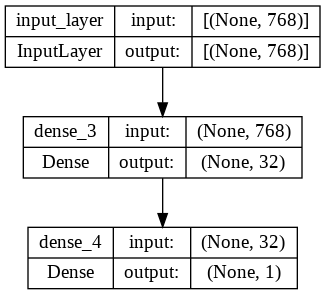

In [39]:
# Define the input layer
input_layer = Input(shape=[768,], name='input_layer')

# Define the third dense layer
dense3 = Dense(32, activation='relu', name='dense_3')(input_layer)

# Define the output layer
output = Dense(1, activation='sigmoid', name='dense_4')(dense3)

# Define the model
model1 = Model(inputs=input_layer, outputs=output)

# Plot the model
tf.keras.utils.plot_model(model1, "model_1.png", show_shapes=True)


In [40]:
opt= tf.keras.optimizers.Adam(learning_rate=0.002)
model1.compile(optimizer=opt,loss=tf.keras.losses.BinaryCrossentropy(),metrics='accuracy')

In [41]:
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 768)]             0         
                                                                 
 dense_3 (Dense)             (None, 32)                24608     
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 24,641
Trainable params: 24,641
Non-trainable params: 0
_________________________________________________________________


In [42]:
!rm -rf ./logs_model1/ 
tf.keras.backend.clear_session()
model1.fit(X_train_pooled_output,y_train,validation_data=(X_test_pooled_output,y_test),epochs=100,callbacks=[history_own])

Epoch 1/100
313/313 [==============================] - 0s 1ms/step

  train_auc :  0.8306639012499999
  val_auc :  0.83078104
1250/1250 [==============================] - 6s 4ms/step - loss: 0.5712 - accuracy: 0.6981 - val_loss: 0.5220 - val_accuracy: 0.7345
Epoch 2/100
313/313 [==============================] - 0s 1ms/step

  train_auc :  0.83866647375
  val_auc :  0.8374801999999999
1250/1250 [==============================] - 5s 4ms/step - loss: 0.5221 - accuracy: 0.7402 - val_loss: 0.4980 - val_accuracy: 0.7583
Epoch 3/100
313/313 [==============================] - 0s 1ms/step

  train_auc :  0.8409424725000001
  val_auc :  0.83858508
1250/1250 [==============================] - 5s 4ms/step - loss: 0.5125 - accuracy: 0.7462 - val_loss: 0.5006 - val_accuracy: 0.7499
Epoch 4/100
313/313 [==============================] - 0s 1ms/step

  train_auc :  0.8522623825
  val_auc :  0.8530068799999999
1250/1250 [==============================] - 5s 4ms/step - loss: 0.5020 - accuracy: 0.7535 -

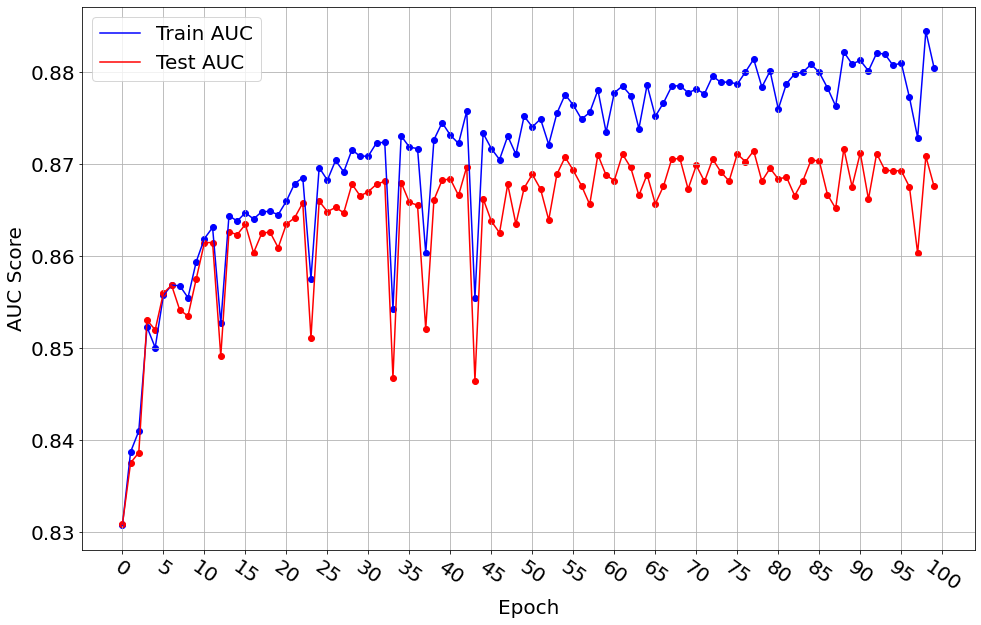

In [43]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(16,10))

plt.plot(np.arange(len(auc)),auc,color="blue")
plt.plot(np.arange(len(auc)),val_auc,color='red')

plt.scatter(np.arange(len(auc)),auc,color='blue')
plt.scatter(np.arange(len(auc)),val_auc,color='red')

plt.xticks(np.arange(0,len(auc)+1,5),rotation=-35)
plt.xlabel('Epoch')
plt.ylabel('AUC Score')
plt.legend(['Train AUC','Test AUC'])
plt.grid()
plt.show()

model2